# Atlas-level integration of lung data

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.


In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "fix_scanvi"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]
    !pip install --quiet git+https://github.com/theislab/scib.git

     |████████████████████████████████| 69 kB 2.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.8 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 242 kB 5.0 MB/s 
     |████████████████████████████████| 213 kB 56.7 MB/s 
     |████████████████████████████████| 678 kB 81.0 MB/s 
     |████████████████████████████████| 813 kB 50.2 MB/s 
     |████████████████████████████████| 91 kB 12.2 MB/s 
     |████████████████████████████████| 8.8 MB 15.6 MB/s 
     |████████████████████████████████| 41 kB 132 kB/s 
     |████████████████████████████████| 1.4 MB 60.9 MB/s 
     |████████████████████████████████| 2.0 MB 30.6 MB/s 
     |███████████████

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi
import scib

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

  0%|          | 0.00/972M [00:00<?, ?B/s]

Note that this dataset has the counts already separated in a layer. Here, `adata.X` contains log transformed scran normalized expression.

In [4]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

### Dataset preprocessing

This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.


Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections. 

In [5]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata, 
    flavor="seurat_v3", 
    n_top_genes=2000, 
    layer="counts", 
    batch_key="batch",
    subset=True
)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

* Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
* Create an SCVI model object.

In [6]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 32472 cells, 2000 vars, 16        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

<div class="alert alert-info">

Important

We see a warning about the data not containing counts. This is due to some of the samples in this dataset containing SoupX-corrected counts. scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts, and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.

</div>

In [7]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

/usr/local/lib/python3.7/dist-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Now we train scVI. This should take a couple of minutes on a Colab session

In [8]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 246/246: 100%|██████████| 246/246 [08:26<00:00,  2.06s/it, loss=553, v_num=1]


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [9]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

/usr/local/lib/python3.7/dist-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Finally, we can cluster the dataset and visualize it with UMAP

In [10]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

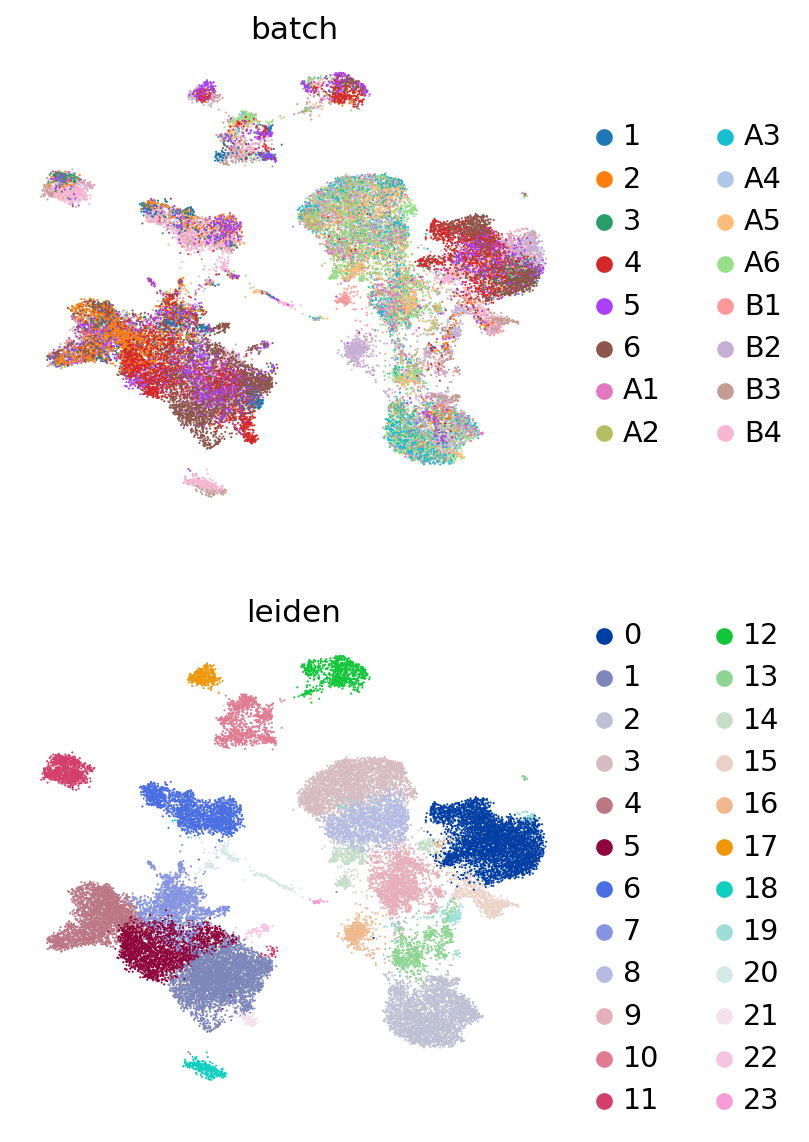

In [11]:
sc.pl.umap(
    adata, 
    color=["batch", "leiden"], 
    frameon=False, 
    ncols=1, 
)

Because this data has been used for benchmarking, we have access here to curated annotations. We can use those to assess whether the integration worked reasonably well. 

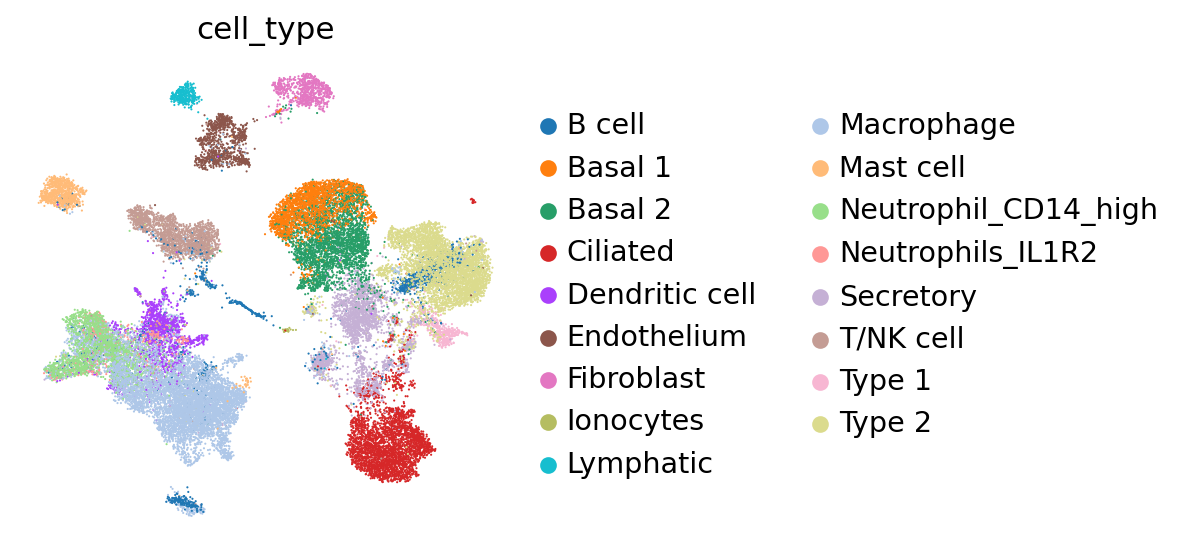

In [12]:
sc.pl.umap(adata, color=["cell_type"], frameon=False, ncols=1)

From a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. We see that this dataset is quite complex, where only some batches contain certain cell types.

### Compute integration metrics

To quantify integration performance, we compute a subset of the metrics from [scIB](https://github.com/theislab/scib). Note that metrics are manipulated/scaled so that higher is always better, and these metrics might not represent the same exact value as when they were originally described (e.g., ilisi, clisi in this case).


In [13]:
%%capture 
def compute_scib_metrics(adata, emb_key, label_key, batch_key, model_name):
    from scib.metrics.silhouette import silhouette_batch, silhouette
    from scib.metrics.lisi import lisi_graph
    import pandas as pd

    emb_key_ = "X_emb"
    adata.obsm[emb_key_] = adata.obsm[emb_key]
    sc.pp.neighbors(adata, use_rep=emb_key_)
    df = pd.DataFrame(index=[model_name])
    df["ilisi"], df["clisi"] = lisi_graph(adata, batch_key, label_key, type_="embed")
    df["sil_batch"] = silhouette_batch(adata, batch_key, label_key, emb_key_)
    df["sil_labels"] = silhouette(adata, label_key, emb_key_)

    return df

emb_key = "X_scVI"
scvi_metrics = compute_scib_metrics(adata, emb_key, "cell_type", "batch", "scVI")

In [14]:
scvi_metrics

,ilisi,clisi,sil_batch,sil_labels
scVI,0.157201,0.986545,0.898827,0.536129


## Integration with scANVI

Previously, we used scVI as we assumed we did not have any cell type annotations available to guide us. Consequently, after the previous analysis, one would have to annotate clusters using differential expression, or by other means.

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI, i.e., our latent data manifold is better suited to downstream tasks like visualization, trajectory inference, or nearest-neighbor-based tasks. scANVI requires:

* the sample identifier for each cell (as in scVI)
* the cell type/state for each cell

scANVI can also be used for label transfer and we recommend checking out the other scANVI tutorials to see explore this functionality.



Now we may register the AnnData object and run scANVI.

In [15]:
scvi.model.SCANVI.setup_anndata(
    adata, 
    layer="counts",
    batch_key="batch", 
    labels_key="cell_type", 
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 32472 cells, 2000 vars, 16        
         batches, 17 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Since we've already trained an scVI model on our data, we will use it to initialize scANVI.  When initializing scANVI, which can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

<div class="alert alert-info">

Important

scANVI should always be initialized from a scVI model pre-trained on the same exact data.

</div>

In [16]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae, 
    unlabeled_category="Unknown", 
    adata=adata
)

/usr/local/lib/python3.7/dist-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


In [17]:
lvae.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it, loss=267, v_num=1]


Now we can retrieve the latent space

In [18]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

/usr/local/lib/python3.7/dist-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


Again, we may visualize the latent space as well as the inferred labels

In [19]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

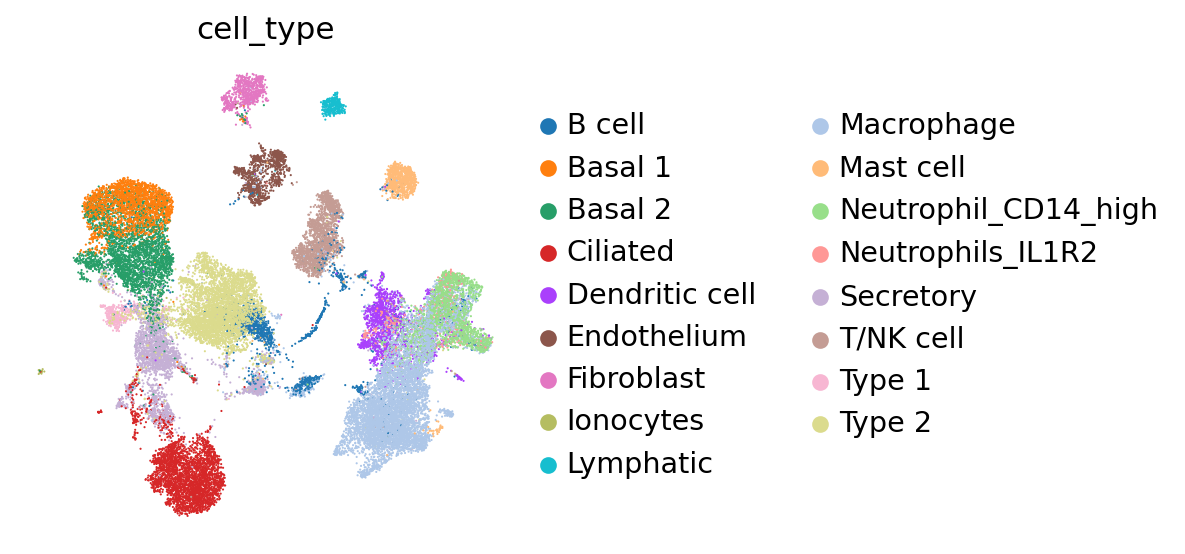

In [20]:
sc.pl.umap(adata, color=["cell_type"], ncols=1, frameon=False)

### Compute integration metrics

We can see that the additional training with label information and scANVI improved the metrics that capture bio conservation (`clisi, sil_labels`) without sacrificing too much batch correction power (`ilisi, sil_batch`)


In [21]:
%%capture
emb_key = "X_scANVI"
scanvi_metrics = compute_scib_metrics(adata, emb_key, "cell_type", "batch", "scANVI")

In [22]:
scanvi_metrics

,ilisi,clisi,sil_batch,sil_labels
scANVI,0.153855,0.992214,0.879924,0.577532


In [23]:
pd.concat([scvi_metrics, scanvi_metrics], axis=0)

,ilisi,clisi,sil_batch,sil_labels
scVI,0.157201,0.986545,0.898827,0.536129
scANVI,0.153855,0.992214,0.879924,0.577532
